In [9]:
import cv2
import numpy as np
import fitz
import pytesseract
import imutils
import matplotlib.pyplot as plt


pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'


def get_pic_from_pdf(pdf_path):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(0)
    pix = page.get_pixmap()
    pix.save('template.png')
    template = cv2.imread('template.png')
    return template

def get_aligned_pic(template_path, filled_form_path):

    template = cv2.imread(template_path, 0)
    filled_form = cv2.imread(filled_form_path, 0)  # Заполненный бланк

    # Нахождение ключевых точек и дескрипторов
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(filled_form, None)

    # Сопоставление точек
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Используем лучшие сопоставления
    good_matches = matches[:50]
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Вычисление матрицы гомографии
    matrix, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # Применение перспективного преобразования
    h, w = template.shape
    aligned_image = cv2.warpPerspective(filled_form, matrix, (w, h))

    # Сохранение результата
    cv2.imwrite('aligned_form.jpg', aligned_image)

    return aligned_image

def get_contours(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Инвертируем изображение (пунктирные линии должны быть белыми)
    _, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

    # Применяем размытие, чтобы убрать шум
    blurred = cv2.GaussianBlur(binary, (5, 5), 0)

    # Используем морфологию для выделения прямоугольных структур
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    processed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Поиск контуров
    contours, _ = cv2.findContours(processed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: x[0][0][1])
    contours = sorted(contours, key=lambda x: x[0][0][0])
    contours = sorted(contours, key=lambda c: (cv2.boundingRect(c)[1], cv2.boundingRect(c)[0]))

    # Копия изображения для отображения результатов
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Фильтруем и выделяем только прямоугольные блоки
    contours_valid = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Условие для фильтрации блоков по размеру
        if 0 < w < 25 and 20 < h < 100:  # Подстраивайте размеры под бланк
            contours_valid.append(contour)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    return contours_valid, output

def visualize_contours(contours, img_path):
    output = cv2.imread(img_path)
    # Бинаризация (порог)
    _, thresh = cv2.threshold(output, 190, 255, cv2.THRESH_BINARY)

    # Морфологическая операция "closing", чтобы убрать разрывы
    kernel = np.ones((1,1), np.uint8)
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Можно слегка «размыть» (blur), если хочется чуть более сглаженные края
    blur = cv2.GaussianBlur(closing, (1,1), 0)

    x, y, w, h = cv2.boundingRect(contours)
    roi = blur[y:y+h, x:x+w]
    plt.imshow(roi, cmap='gray')
    plt.axis('off')
    plt.show()

def recognize_text(image_path):
    image = cv2.imread(image_path,0)
    image = imutils.resize(image, width=300)
    thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    result = 255 - close 
    result = cv2.GaussianBlur(result, (5,5), 0)

    data = pytesseract.image_to_string(result, config='--psm 10', lang='eng')
    processed_data = ''.join(char for char in data if char.isnumeric() or char == ',')

    plt.imshow(thresh, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(close, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(result[10:100, 80:100], cmap='gray')
    plt.axis('off')
    plt.show()

    return processed_data

In [11]:
# aligned_image = get_aligned_pic('reference.jpg', 'cur_temp_pic_0.png')
# contours, output = get_contours("reference.jpg")
# for contour in contours:
#     visualize_contours(contour, 'aligned_form.jpg')

In [1]:
# for contour in contours:
#     visualize_contours(contour, 'aligned_form.jpg')

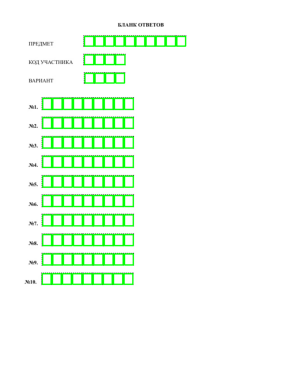

In [12]:
contours, output = get_contours("reference.jpg")

# Display the manually defined grid cells
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [4]:
import json
import pandas as pd
class Cell:
    def __init__(self, row_name):
        """
        Класс, представляющий одну клетку.
        
        :param row_name: Название строки, к которой относится клетка
        """
        self.row_name = row_name
        self.cell_number = None
        self.x = None
        self.y = None
        self.w = None
        self.h = None
        self.value = None
        self.cell_number = None

    def __repr__(self):
        return (f"Cell(row_name={self.row_name}, cell_number={self.cell_number}, "
                f"x={self.x}, y={self.y}, w={self.w}, h={self.h}, value={self.value}")

    def load_from_dict(self, cell_dict):
        """
        Заполняем поля клетки из словаря (обычно загружается из JSON).
        """
        self.x = cell_dict.get("x")
        self.y = cell_dict.get("y")
        self.w = cell_dict.get("w")
        self.h = cell_dict.get("h")
        self.value = cell_dict.get("value")
        self.cell_number = cell_dict.get("cell_number")

class Row:
    def __init__(self, row_name):
        self.row_name = row_name
        # Сразу создаём 10 объектов Cell
        # (каждому можно проставить cell_number = i)
        self.cells = [Cell(row_name) for _ in range(10)]

    def load_data(self, row_dict):
        """
        row_dict ожидается вида:
        {
          "cell1": { "x": ..., "y": ... },
          "cell2": { "x": ..., "y": ... },
          ...
        }
        """
        for i in range(10):
            cell_key = f"cell{i+1}"  # cell1..cell10
            if cell_key in row_dict:
                # self.cells[i].cell_number = i + 1
                self.cells[i].load_from_dict(row_dict[cell_key])

    def __repr__(self):
        return f"Row('{self.row_name}', cells={self.cells})"

class Form:
    def __init__(self, contours=None):
        """
        contours — возможно, вам нужно передавать сюда какие-то контуры или
        иной массив данных, но для упрощённого примера можно оставить как есть.
        """
        self.header = Row("header")
        self.subject = Row("subject")
        self.user_code = Row("user_code")
        self.version = Row("version")
        self.task1 = Row("task1")
        self.task2 = Row("task2")
        self.task3 = Row("task3")
        self.task4 = Row("task4")
        self.task5 = Row("task5")
        self.task6 = Row("task6")
        self.task7 = Row("task7")
        self.task8 = Row("task8")
        self.task9 = Row("task9")
        self.task10 = Row("task10")

    def __repr__(self):
        return (
            f"Form("
            f"header={self.header}, "
            f"subject={self.subject}, "
            f"user_code={self.user_code}, "
            f"version={self.version}, "
            f"task1={self.task1}, "
            f"task2={self.task2}, "
            f"task3={self.task3}, "
            f"task4={self.task4}, "
            f"task5={self.task5}, "
            f"task6={self.task6}, "
            f"task7={self.task7}, "
            f"task8={self.task8}, "
            f"task9={self.task9}, "
            f"task10={self.task10})"
        )

    def load_from_json(self, json_path):
        """
        Читаем файл JSON и заполняем все поля (строки).
        Структура JSON должна быть такая, чтобы для каждого row
        (header, subject, user_code и т.д.) были данные по cell1..cell10.
        """
        with open(json_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Предполагаем, что в data лежит словарь вида:
        # {
        #   "header": { "cell1": {...}, "cell2": {...}, ... },
        #   "subject": { ... },
        #   ...
        # }
        if "header" in data:
            self.header.load_data(data["header"])
        if "subject" in data:
            self.subject.load_data(data["subject"])
        if "user_code" in data:
            self.user_code.load_data(data["user_code"])
        if "version" in data:
            self.version.load_data(data["version"])
        if "task1" in data:
            self.task1.load_data(data["task1"])
        if "task2" in data:
            self.task2.load_data(data["task2"])
        if "task3" in data:
            self.task3.load_data(data["task3"])
        if "task4" in data:
            self.task4.load_data(data["task4"])
        if "task5" in data:
            self.task5.load_data(data["task5"])
        if "task6" in data:
            self.task6.load_data(data["task6"])
        if "task7" in data:
            self.task7.load_data(data["task7"])
        if "task8" in data:
            self.task8.load_data(data["task8"])
        if "task9" in data:
            self.task9.load_data(data["task9"])
        if "task10" in data:
            self.task10.load_data(data["task10"])

    def load_correct_answers(self, excel_path):
        df = pd.read_excel(excel_path)
        for i in range(10):
            self.task1.cells[i].value = df.iloc[i, 0]



form = Form()
form.load_from_json("cells_template.json")
print(form)




Form(header=Row('header', cells=[Cell(row_name=header, cell_number=1, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=2, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=3, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=4, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=5, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=6, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=7, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=8, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=9, x=0, y=0, w=0, h=0, value=0, Cell(row_name=header, cell_number=10, x=0, y=0, w=0, h=0, value=0]), subject=Row('subject', cells=[Cell(row_name=subject, cell_number=1, x=0, y=0, w=0, h=0, value=0, Cell(row_name=subject, cell_number=2, x=0, y=0, w=0, h=0, value=0, Cell(row_name=subject, cell_number=3, x=0, y=0, w=0, h=0, value=0, Cell(row_name=subject, cell_number=4, x=0, y=0, w=0, h=0, value=0, Cell(r

In [2]:
form.header.cells


[Cell(row_name=header, cell_number=1, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=2, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=3, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=4, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=5, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=6, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=7, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=8, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=9, x=0, y=0, w=0, h=0, value=0,
 Cell(row_name=header, cell_number=10, x=0, y=0, w=0, h=0, value=0]

In [16]:
def load_correct_answers(excel_path):
    correct_answers = pd.read_excel(excel_path)
    for col in correct_answers.columns:
        correct_answers[col] = correct_answers[col].astype(str)
    correct_answers = correct_answers.set_index("Вариант")
    correct_answers = correct_answers.T.to_dict()
    return correct_answers

correct_answers = load_correct_answers("answers.xlsx")
correct_answers

{'1': {1: '-98',
  2: '240',
  3: '0',
  4: '150',
  5: '16,9',
  6: '280',
  7: '-8',
  8: '-54',
  9: '10,8',
  10: '4,5'},
 '2': {1: '-275',
  2: '37,5',
  3: '14',
  4: '3478',
  5: '24,5',
  6: '102',
  7: '-3',
  8: '-0,5',
  9: '17,5',
  10: '-0,75'},
 '3': {1: '-2',
  2: '5',
  3: '0',
  4: '88642',
  5: '8,5',
  6: '-35',
  7: '-16',
  8: '-9',
  9: '12',
  10: '0,625'},
 '4': {1: '-2',
  2: '30',
  3: '5',
  4: '92',
  5: '60',
  6: '5',
  7: '-4',
  8: '-2',
  9: '30',
  10: '4,25'},
 '5': {1: '-0,9',
  2: '60',
  3: '2',
  4: '33',
  5: '12',
  6: '17',
  7: '9',
  8: '0,25',
  9: '86,4',
  10: '-0,25'},
 '6': {1: '2',
  2: '20',
  3: '1,08',
  4: '16',
  5: '20',
  6: '13500',
  7: '6',
  8: '4',
  9: '7',
  10: '-50'}}

In [122]:
import pandas as pd
import base64
from openai import OpenAI
import json
from pydantic import BaseModel
import cv2
import numpy as np
import fitz
from PIL import Image
from io import BytesIO
pd.set_option('display.max_columns', None)

class ResearchPaperExtraction(BaseModel):
  subject: str
  participant_code: str
  variant: str
  answers_1: float
  answers_2: float
  answers_3: float
  answers_4: float
  answers_5: float
  answers_6: float
  answers_7: float
  answers_8: float
  answers_9: float
  answers_10: float

def encode_image(image):
# Convert the NumPy array to a PIL Image
    image = Image.fromarray(image)

    # Save the image to a BytesIO buffer in PNG format
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    buffer.seek(0)

    # Encode the PNG image to base64
    test_pic_bytes = buffer.getvalue()
    base64_encoded = base64.b64encode(test_pic_bytes).decode('utf-8')

    return base64_encoded

def extract_text_from_image(api_key, image):
    client = OpenAI(api_key=api_key)

    # Getting the base64 string
    base64_image = encode_image(image)

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Please extract the text and numeric data from the provided image of a completed form. The form contains sequences of cells, with each cell containing a single character. The characters can include letters, digits, the minus sign, commas, and other punctuation marks. Ensure to capture each character exactly as it appears in its respective cell and maintain the order in which the cells are arranged on the form."
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}",
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
        response_format={
                'type': 'json_schema',
                'json_schema':
                    {
                        "name": "whocares",
                        "schema": ResearchPaperExtraction.model_json_schema()
                    }},
    )

    json_response = json.loads(response.choices[0].message.content)
    return json_response

def transform_json_to_dataframe(parsed_json):
  df = pd.DataFrame([parsed_json])
  order = ['subject', 'participant_code', 'variant', 'answers_1', 'answers_2', 'answers_3', 'answers_4', 'answers_5', 'answers_6', 'answers_7', 'answers_8', 'answers_9', 'answers_10']
  df = df[order]
  rename_dict = {
    'subject': 'Предмет',
    'participant_code': 'Код участника',
    'variant': 'Вариант',
    'index': 'Номер вопроса',
    'answers_1': 'Ответ 1',
    'answers_2': 'Ответ 2',
    'answers_3': 'Ответ 3',
    'answers_4': 'Ответ 4',
    'answers_5': 'Ответ 5',
    'answers_6': 'Ответ 6',
    'answers_7': 'Ответ 7',
    'answers_8': 'Ответ 8',
    'answers_9': 'Ответ 9',
    'answers_10': 'Ответ 10'
  }
  df.rename(columns=rename_dict, inplace=True)
  return df

def get_pic_from_pdf(pdf_path, index):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(index)
    pix = page.get_pixmap()
    pix.save(f'cur_temp_pic_{index}.png')
    template = cv2.imread(f'cur_temp_pic_{index}.png', 0)
    return template


def get_correct_answers(correct_answers_path):
    correct_answers = pd.read_excel(correct_answers_path)
    for col in correct_answers.columns:
        if col != 'Вариант':
            correct_answers[col] = correct_answers[col].astype(str)
            correct_answers[col] = correct_answers[col].apply(lambda x: x.replace(',', '.'))
            correct_answers[col] = correct_answers[col].astype(float)
            correct_answers[col] = correct_answers[col].astype(str)
    correct_answers['Вариант'] = correct_answers['Вариант'].astype(str)
    correct_answers.rename(columns={1: "Правильный ответ 1", 2: "Правильный ответ 2", 3: "Правильный ответ 3", 4: "Правильный ответ 4", 5: "Правильный ответ 5", 6: "Правильный ответ 6", 7: "Правильный ответ 7", 8: "Правильный ответ 8", 9: "Правильный ответ 9", 10: "Правильный ответ 10"}, inplace=True)
    return correct_answers

def postprocess_raw_output(df_global_fin, correct_answers):
    df_global_fin['Предмет'] = df_global_fin['Предмет'].str.upper()
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(int)
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(str)
    for i in range(1, 11):
        df_global_fin[f'Ответ {i}'] = df_global_fin[f'Ответ {i}'].astype(float)
    for col in df_global_fin.columns:
        df_global_fin[col] = df_global_fin[col].astype(str)

    total_df = pd.merge(df_global_fin, correct_answers, on="Вариант", how="left")

    return total_df

def check_answers(total_df):

    scores_dict = {
    1: 0.5,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1.5
    }

    for i in range(1, 11):
        total_df[f'Верно {i}'] = (total_df[f'Правильный ответ {i}'] == total_df[f'Ответ {i}']).replace(True, 'Верно').replace(False, 'Неверно')
        total_df[f'Начисленные баллы {i}'] = total_df[f'Верно {i}'].apply(lambda x: scores_dict[i] if x == 'Верно' else 0)

    total_df['Начисленные баллы сумма'] = total_df[[f'Начисленные баллы {i}' for i in range(1, 11)]].sum(axis=1)

    return total_df

def final_styling(total_df):
    reorder_cols_list = ['Предмет', 'Код участника', 'Вариант', 'Начисленные баллы сумма']
    for i in range(1, 11):  
        reorder_cols_list.append(f'Ответ {i}')
        reorder_cols_list.append(f'Правильный ответ {i}')
        reorder_cols_list.append(f'Верно {i}')
        reorder_cols_list.append(f'Начисленные баллы {i}')
    total_df = total_df[reorder_cols_list]

    return total_df

api_key = ''
pdf_path = "Сканы бланков ответов.PDF"

def run_pipeline(pdf_path, answers_path,api_key):
    pdf_document = fitz.open(pdf_path)
    num_pages = pdf_document.page_count

    df_global = pd.DataFrame()
    for i in range(num_pages):
        cur_pic = get_pic_from_pdf(pdf_path, i)
        global test_pic
        test_pic = cur_pic
        parsed_json = extract_text_from_image(api_key, cur_pic)
        df_current = transform_json_to_dataframe(parsed_json)
        df_global = pd.concat([df_global, df_current]).reset_index(drop=True)

    correct_answers = get_correct_answers(answers_path)
    df_global_processed = postprocess_raw_output(df_global, correct_answers)
    df_global_answers = check_answers(df_global_processed)
    df_global_styled = final_styling(df_global_answers)
    
    return df_global_styled

pdf_path = 'scans.pdf'
answers_path = 'answers.xlsx'
df_global_fin_raw = run_pipeline(pdf_path, answers_path, api_key)

In [124]:
pip install streamlit

  Using cached streamlit-1.41.1-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyarrow-18.1.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl.metadata (7.1 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached narwhals-1.20.1-py3-none-any.whl.metadata (11 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached attrs-24.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.35.1-py3-none-any


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [118]:
for i in range(1, 11):
    df_global_fin_raw[f'Ответ {i}'] = df_global_fin_raw[f'Ответ {i}'].astype(float)

In [119]:
df_global_fin_raw

,Предмет,Код участника,Вариант,Начисленные баллы сумма,Ответ 1,Правильный ответ 1,Верно 1,Начисленные баллы 1,Ответ 2,Правильный ответ 2,Верно 2,Начисленные баллы 2,Ответ 3,Правильный ответ 3,Верно 3,Начисленные баллы 3,Ответ 4,Правильный ответ 4,Верно 4,Начисленные баллы 4,Ответ 5,Правильный ответ 5,Верно 5,Начисленные баллы 5,Ответ 6,Правильный ответ 6,Верно 6,Начисленные баллы 6,Ответ 7,Правильный ответ 7,Верно 7,Начисленные баллы 7,Ответ 8,Правильный ответ 8,Верно 8,Начисленные баллы 8,Ответ 9,Правильный ответ 9,Верно 9,Начисленные баллы 9,Ответ 10,Правильный ответ 10,Верно 10,Начисленные баллы 10
0,МАТЕМАТИКА,1234,1,2.0,-98.0,-98.0,Неверно,0.0,240.0,240.0,Неверно,0,0.0,0.0,Неверно,0,15.0,150.0,Неверно,0,16.9,16.9,Верно,1,270.0,280.0,Неверно,0,8.0,-8.0,Неверно,0,-54.00,-54.0,Неверно,0,10.8,10.8,Верно,1,45.000,4.5,Неверно,0.0
1,МАТЕМАТИКА,1235,5,2.0,0.9,-0.9,Неверно,0.0,60.0,60.0,Неверно,0,2.0,2.0,Неверно,0,13.0,33.0,Неверно,0,17.0,12.0,Неверно,0,17.0,17.0,Неверно,0,9.0,9.0,Неверно,0,0.25,0.25,Верно,1,86.4,86.4,Верно,1,5.000,-0.25,Неверно,0.0
2,МАТЕМАТИКА,1235,5,3.0,-0.9,-0.9,Верно,0.5,50.0,60.0,Неверно,0,2.0,2.0,Неверно,0,66.0,33.0,Неверно,0,12.0,12.0,Неверно,0,17.0,17.0,Неверно,0,10.0,9.0,Неверно,0,2.50,0.25,Неверно,0,86.4,86.4,Верно,1,-0.250,-0.25,Верно,1.5
3,МАТЕМАТИКА,1234,3,0.0,-2.0,-2.0,Неверно,0.0,10.0,5.0,Неверно,0,5.0,0.0,Неверно,0,90.0,88642.0,Неверно,0,60.0,8.5,Неверно,0,5.0,-35.0,Неверно,0,-16.0,-16.0,Неверно,0,-9.00,-9.0,Неверно,0,12.0,12.0,Неверно,0,1125.000,0.625,Неверно,0.0
4,МАТЕМАТИКА,2014,3,1.5,-2.0,-2.0,Неверно,0.0,5.0,5.0,Неверно,0,1.0,0.0,Неверно,0,88642.0,88642.0,Неверно,0,9.5,8.5,Неверно,0,-35.0,-35.0,Неверно,0,-16.0,-16.0,Неверно,0,-10.00,-9.0,Неверно,0,12.0,12.0,Неверно,0,0.625,0.625,Верно,1.5
5,MATEMATIKA,1234,2,3.0,275.0,-275.0,Неверно,0.0,37.5,37.5,Верно,1,14.0,14.0,Неверно,0,3478.0,3478.0,Неверно,0,24.6,24.5,Неверно,0,102.0,102.0,Неверно,0,-3.0,-3.0,Неверно,0,-0.50,-0.5,Верно,1,17.5,17.5,Верно,1,0.750,-0.75,Неверно,0.0
6,МАТЕМАТИКА,1234,3,2.5,-2.0,-2.0,Неверно,0.0,5.0,5.0,Неверно,0,0.0,0.0,Неверно,0,88642.0,88642.0,Неверно,0,8.5,8.5,Верно,1,-35.0,-35.0,Неверно,0,16.0,-16.0,Неверно,0,-9.00,-9.0,Неверно,0,-12.0,12.0,Неверно,0,0.625,0.625,Верно,1.5
7,МАТЕМАТИКА,1234,4,0.0,-2.0,-2.0,Неверно,0.0,-30.0,30.0,Неверно,0,5.0,5.0,Неверно,0,92.0,92.0,Неверно,0,60.3,60.0,Неверно,0,5.0,5.0,Неверно,0,4.0,-4.0,Неверно,0,-2.00,-2.0,Неверно,0,-30.0,30.0,Неверно,0,42.500,4.25,Неверно,0.0


In [116]:
df_global_fin_raw[['Ответ 3', 'Правильный ответ 3', 'Верно 3', 'Начисленные баллы 3']]


,Ответ 3,Правильный ответ 3,Верно 3,Начисленные баллы 3
0,0,0.0,Неверно,0
1,2,2.0,Неверно,0
2,2,2.0,Неверно,0
3,5,0.0,Неверно,0
4,1,0.0,Неверно,0
5,14,14.0,Неверно,0
6,0,0.0,Неверно,0
7,5,5.0,Неверно,0


In [ ]:
df_global_fin_raw

In [105]:
df_global_fin = df_global_fin_raw.copy()

In [107]:
def get_correct_answers(correct_answers_path):
    correct_answers = pd.read_excel(correct_answers_path)
    for col in correct_answers.columns:
        if col != 'Вариант':
            correct_answers[col] = correct_answers[col].astype(str)
            correct_answers[col] = correct_answers[col].apply(lambda x: x.replace(',', '.'))
            correct_answers[col] = correct_answers[col].astype(float)
            correct_answers[col] = correct_answers[col].astype(str)
    correct_answers['Вариант'] = correct_answers['Вариант'].astype(str)
    correct_answers.rename(columns={1: "Правильный ответ 1", 2: "Правильный ответ 2", 3: "Правильный ответ 3", 4: "Правильный ответ 4", 5: "Правильный ответ 5", 6: "Правильный ответ 6", 7: "Правильный ответ 7", 8: "Правильный ответ 8", 9: "Правильный ответ 9", 10: "Правильный ответ 10"}, inplace=True)
    return correct_answers

def postprocess_raw_output(df_global_fin, correct_answers):
    df_global_fin['Предмет'] = df_global_fin['Предмет'].str.upper()
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(int)
    df_global_fin['Вариант'] = df_global_fin['Вариант'].astype(str)
    for col in df_global_fin.columns:
        df_global_fin[col] = df_global_fin[col].astype(str)

    total_df = pd.merge(df_global_fin, correct_answers, on="Вариант", how="left")

    return total_df

def check_answers(total_df):

    scores_dict = {
    1: 0.5,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1.5
    }

    for i in range(1, 11):
        total_df[f'Верно {i}'] = (total_df[f'Правильный ответ {i}'] == total_df[f'Ответ {i}']).replace(True, 'Верно').replace(False, 'Неверно')
        total_df[f'Начисленные баллы {i}'] = total_df[f'Верно {i}'].apply(lambda x: scores_dict[i] if x == 'Верно' else 0)

    total_df['Начисленные баллы сумма'] = total_df[[f'Начисленные баллы {i}' for i in range(1, 11)]].sum(axis=1)

    return total_df

def final_styling(total_df):
    reorder_cols_list = ['Предмет', 'Код участника', 'Вариант', 'Начисленные баллы сумма']
    for i in range(1, 11):  
        reorder_cols_list.append(f'Ответ {i}')
        reorder_cols_list.append(f'Правильный ответ {i}')
        reorder_cols_list.append(f'Верно {i}')
        reorder_cols_list.append(f'Начисленные баллы {i}')
    total_df = total_df[reorder_cols_list]

    return total_df


correct_answers = get_correct_answers("answers.xlsx")
total_df = postprocess_raw_output(df_global_fin, correct_answers)
total_df = check_answers(total_df)
total_df = final_styling(total_df)

total_df



,Предмет,Код участника,Вариант,Начисленные баллы сумма,Ответ 1,Правильный ответ 1,Верно 1,Начисленные баллы 1,Ответ 2,Правильный ответ 2,Верно 2,Начисленные баллы 2,Ответ 3,Правильный ответ 3,Верно 3,Начисленные баллы 3,Ответ 4,Правильный ответ 4,Верно 4,Начисленные баллы 4,Ответ 5,Правильный ответ 5,Верно 5,Начисленные баллы 5,Ответ 6,Правильный ответ 6,Верно 6,Начисленные баллы 6,Ответ 7,Правильный ответ 7,Верно 7,Начисленные баллы 7,Ответ 8,Правильный ответ 8,Верно 8,Начисленные баллы 8,Ответ 9,Правильный ответ 9,Верно 9,Начисленные баллы 9,Ответ 10,Правильный ответ 10,Верно 10,Начисленные баллы 10
0,МАТЕМАТИКА,1234,1,5.5,-98.0,-98.0,Верно,0.5,240.0,240.0,Верно,1,0.0,0.0,Верно,1,15.0,150.0,Неверно,0,16.9,16.9,Верно,1,270.0,280.0,Неверно,0,8.0,-8.0,Неверно,0,-54.0,-54.0,Верно,1,10.8,10.8,Верно,1,45.0,4.5,Неверно,0.0
1,МАТЕМАТИКА,1235,5,6.5,-0.9,-0.9,Верно,0.5,60.0,60.0,Верно,1,2.0,2.0,Верно,1,13.0,33.0,Неверно,0,17.0,12.0,Неверно,0,17.0,17.0,Верно,1,9.0,9.0,Верно,1,0.25,0.25,Верно,1,86.4,86.4,Верно,1,5.0,-0.25,Неверно,0.0
2,МАТЕМАТИКА,1235,5,4.0,0.9,-0.9,Неверно,0.0,50.0,60.0,Неверно,0,2.0,2.0,Верно,1,66.0,33.0,Неверно,0,12.0,12.0,Верно,1,17.0,17.0,Верно,1,10.0,9.0,Неверно,0,2.5,0.25,Неверно,0,86.4,86.4,Верно,1,0.25,-0.25,Неверно,0.0
3,МАТЕМАТИКА,1234,3,3.5,-2.0,-2.0,Верно,0.5,10.0,5.0,Неверно,0,5.0,0.0,Неверно,0,90.0,88642.0,Неверно,0,60.0,8.5,Неверно,0,5.0,-35.0,Неверно,0,-16.0,-16.0,Верно,1,-9.0,-9.0,Верно,1,12.0,12.0,Верно,1,1.125,0.625,Неверно,0.0
4,МАТЕМАТИКА,2014,3,7.0,-2.0,-2.0,Верно,0.5,5.0,5.0,Верно,1,1.0,0.0,Неверно,0,88642.0,88642.0,Верно,1,9.5,8.5,Неверно,0,-35.0,-35.0,Верно,1,-16.0,-16.0,Верно,1,-10.0,-9.0,Неверно,0,12.0,12.0,Верно,1,0.625,0.625,Верно,1.5
5,МАТЕМАТИКА,1234,2,7.0,275.0,-275.0,Неверно,0.0,37.5,37.5,Верно,1,14.0,14.0,Верно,1,3478.0,3478.0,Верно,1,24.6,24.5,Неверно,0,102.0,102.0,Верно,1,-3.0,-3.0,Верно,1,-0.5,-0.5,Верно,1,17.5,17.5,Верно,1,0.75,-0.75,Неверно,0.0
6,МАТЕМАТИКА,1234,3,8.0,-2.0,-2.0,Верно,0.5,5.0,5.0,Верно,1,0.0,0.0,Верно,1,88642.0,88642.0,Верно,1,8.5,8.5,Верно,1,-35.0,-35.0,Верно,1,16.0,-16.0,Неверно,0,-9.0,-9.0,Верно,1,-12.0,12.0,Неверно,0,0.625,0.625,Верно,1.5
7,МАТЕМАТИКА,1234,4,4.5,-2.0,-2.0,Верно,0.5,-30.0,30.0,Неверно,0,5.0,5.0,Верно,1,92.0,92.0,Верно,1,60.3,60.0,Неверно,0,5.0,5.0,Верно,1,4.0,-4.0,Неверно,0,-2.0,-2.0,Верно,1,-30.0,30.0,Неверно,0,42.5,4.25,Неверно,0.0
